In [1]:
import os
import sys
import random
import pickle
import datetime

import numpy as np
import torchmetrics
import torchsummary
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import seaborn as sns



sys.path.insert(0, "C:\Projects\DateMatching\Model") 
import utils

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Prepare data

In [2]:
embeder = utils.EmbedingStorage('weights/emb_storage.pkl')

In [3]:
emb1 = embeder[20880]
emb2 = embeder[20881]
print('similarity', (emb1/np.linalg.norm(emb1)) @ (emb2/np.linalg.norm(emb2)).T)

similarity [[0.81257343]]


In [4]:
files_opposite = []
files_target = []

path = "data/opposite/"
files_opposite += [embeder[int(f.split('.')[0])] for f in os.listdir(path) if f != '.gitkeep']

path =  "data/target/"
files_target += [embeder[int(f.split('.')[0])] for f in os.listdir(path) if f != '.gitkeep']

files_opposite = np.array(files_opposite)
files_target = np.array(files_target)

y_opposite = np.zeros(len(files_opposite), dtype='float32')
y_target = np.ones(len(files_target), dtype='float32')

X = np.concatenate([files_opposite, files_target])[:, 0]
Y = np.concatenate([y_opposite, y_target])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=69)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=69)

In [5]:
Y.shape, X.shape

((20845,), (20845, 512))

In [6]:
Ytrain.sum(), Yval.sum(), Ytest.sum()

(82.0, 23.0, 30.0)

# Train

### evaluate

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve


def evaluate(y_true, y_pred):
    print(f"accuracy  {accuracy_score(y_true, y_pred.round())}")
    print(f"AUC       {roc_auc_score(y_true, y_pred)}")
    print(f"precision {precision_score(y_true, y_pred.round())}")
    print(f"recall    {recall_score(y_true, y_pred.round())}")
    print(f"f1        {f1_score(y_true, y_pred.round())}")
    
    p, r, t = precision_recall_curve(y_true, y_pred)
    
    plt.plot(p, r, label='precision_recall_curve')
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.show()

### KNeighbors Classifier

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier

nca = NeighborhoodComponentsAnalysis()
knn = KNeighborsClassifier(n_neighbors=2)

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(Xtrain, Ytrain);

accuracy  0.9956824178460062
AUC       0.8150157042763952
precision 0.9285714285714286
recall    0.43333333333333335
f1        0.5909090909090909


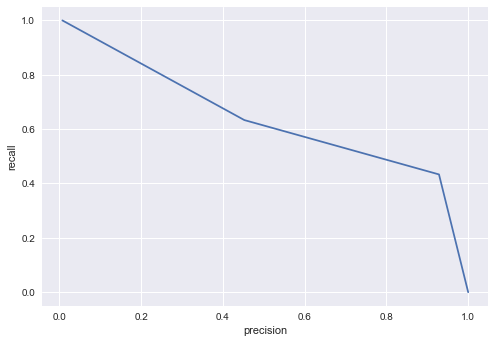

In [9]:
pred = nca_pipe.predict_proba(Xtest)
evaluate(Ytest, pred[:, 1])

### NearestCentroid

In [10]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(Xtrain, Ytrain);

accuracy  0.8522427440633246
AUC       0.760127244906177
precision 0.03194888178913738
recall    0.6666666666666666
f1        0.06097560975609756


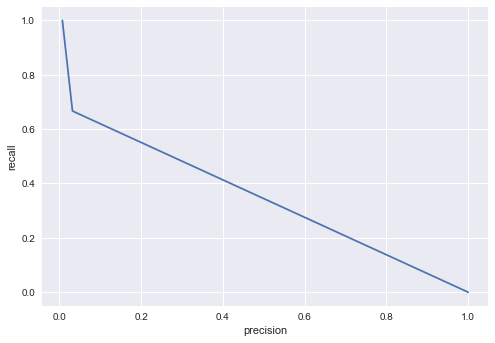

In [11]:
pred = clf.predict(Xtest)
evaluate(Ytest, pred)

### SVC

accuracy  0.99616214919645
AUC       0.8759120560521865
precision 1.0
recall    0.4666666666666667
f1        0.6363636363636364


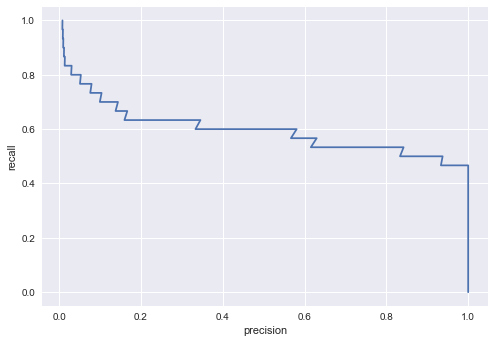

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(Xtrain, Ytrain)

pred = clf.predict_proba(Xtest)
evaluate(Ytest, pred[:, 1])

### SVR

accuracy  0.9959222835212281
AUC       0.8757751469759202
precision 1.0
recall    0.43333333333333335
f1        0.6046511627906976


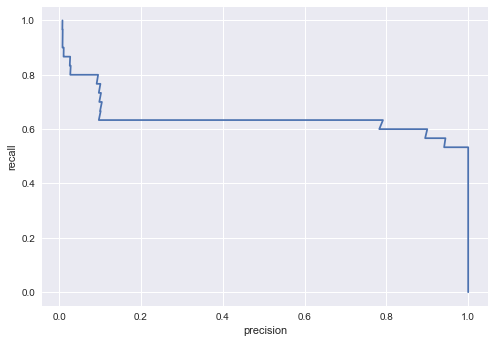

In [17]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVR())
clf.fit(Xtrain, Ytrain)

pred = clf.predict(Xtest)
evaluate(Ytest, pred)

### catboost

accuracy  0.9935236267690094
AUC       0.8406217282757511
precision 1.0
recall    0.1
f1        0.18181818181818182


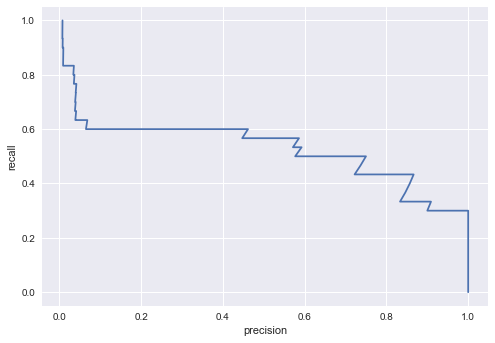

In [18]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000)
model.fit(Xtrain, Ytrain, verbose=False)

pred = model.predict_proba(Xtest)
evaluate(Ytest, pred[:, 1])

### NN

In [100]:
def expand_y(Y):
    return np.concatenate([Y[:, None], Y[:, None]*-1+1], axis=-1)

In [124]:
trainLoader = torch.utils.data.DataLoader(
    utils.EmbedDataset(
        x=Xtrain, 
        y=expand_y(Ytrain),
        decompositor=None), 
    batch_size=2048, 
)

In [125]:
valLoader = torch.utils.data.DataLoader(
    utils.TestDataset(
        x=Xval, 
        y=expand_y(Yval),
        decompositor=None), 
    batch_size=2048, 
)

In [126]:
testLoader = torch.utils.data.DataLoader(
    utils.TestDataset(
        x=Xtest, 
        y=expand_y(Ytest), 
        decompositor=None), 
    batch_size=2048, 
)

In [246]:
model = utils.Model(Xtrain.shape[1], d=[32, 32]).to(DEVICE)
trainer = utils.Trainer(
    model=model,
    stop_batch=10_000/2048,
    device=DEVICE,
    metric=torchmetrics.AUROC(num_classes=2),
    loss_fn=nn.CrossEntropyLoss(reduce=True),
    optimizer=torch.optim.Adam(model.parameters(), lr=3e-4),
)

acc = torchmetrics.Accuracy()
auc = torchmetrics.AUROC()

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [247]:
torchsummary.summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       16,416
|    └─Dropout: 2-2                      --
|    └─GELU: 2-3                         --
|    └─Linear: 2-4                       1,056
|    └─Dropout: 2-5                      --
|    └─GELU: 2-6                         --
|    └─Linear: 2-7                       66
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0


In [248]:
name = 'pca free'
board_name = name + datetime.datetime.now().strftime("%Y.%m.%d - %H-%M-%S")

log_dir = f"logs/fit/{board_name}"
writer = SummaryWriter(log_dir)

In [249]:
try:
    wait = 0
    patience = 50
    
    epoch = 0
    best_loss = -np.inf
    while wait < patience:
        train_loss = trainer.train(trainLoader, epoch)

        val_pred, val_true = trainer.val(valLoader)
        val_pred, val_true = val_pred[:, 0], val_true[:, 0]
        metrics = {
            'AUC': auc(val_pred.sigmoid(), val_true.int()),
            'ACC': acc(val_pred.sigmoid(), val_true.int()),
        }
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('AUC/train', trainer.metric.compute(), epoch)
        writer.add_scalar('AUC/val', metrics['AUC'], epoch)
        writer.add_scalar('ACC/val', metrics['ACC'], epoch)


        wait+=1
        epoch+=1
        if metrics['AUC'] > best_loss:
            checkpoint = trainer.checkpoint()
            torch.save(checkpoint, f'weights/w/{name}.torch')
            best_loss = metrics['AUC']
            wait = 0


except KeyboardInterrupt:
    print("KeyboardInterrupt")

accuracy  0.9865675221875749
AUC       0.8526375130868971
precision 0.27586206896551724
recall    0.5333333333333333
f1        0.36363636363636365


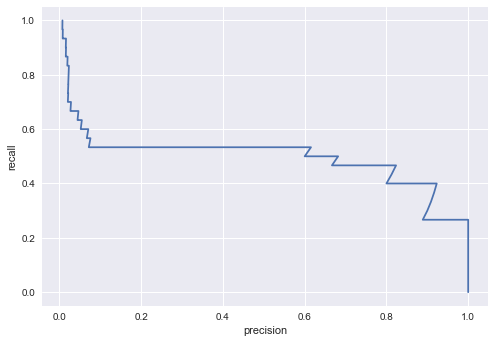

In [250]:
checkpoint = torch.load(f'weights/w/{name}.torch')
model.load_state_dict(checkpoint['model'])

test_pred, test_true = trainer.val(testLoader)
test_pred, test_true = test_pred.softmax(dim=1)[:, 0], test_true[:, 0]
evaluate(test_true, test_pred)

accuracy  0.9923242983928999
AUC       0.8650157042763953
precision 0.4722222222222222
recall    0.5666666666666667
f1        0.5151515151515152


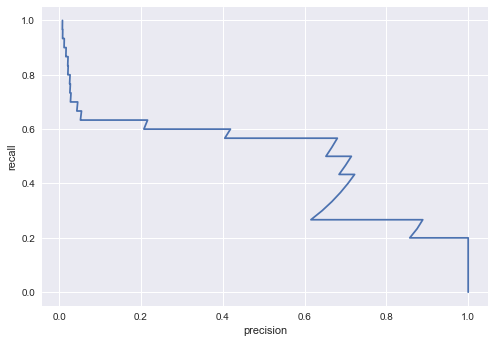

In [245]:
checkpoint = torch.load(f'weights/w/{name}.torch')
model.load_state_dict(checkpoint['model'])

test_pred, test_true = trainer.val(testLoader)
test_pred, test_true = test_pred.softmax(dim=1)[:, 0], test_true[:, 0]
evaluate(test_true, test_pred)

In [211]:
torch.save(checkpoint, f'weights/w/prod.torch')